In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from implementations import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the training data into feature matrix, class labels, and event ids:

In [14]:
import datetime
from proj1_helpers import *

DATA_TRAIN_PATH = 'data/train.csv' 
y, X, ids = load_csv_data(DATA_TRAIN_PATH)
X.shape

(250000, 30)

# Data preprocessing
## Missing Values

In [15]:
from missing_values import *

interpolator = MeanInterpolator()
X = interpolator.interpolate(X)

## Outliers

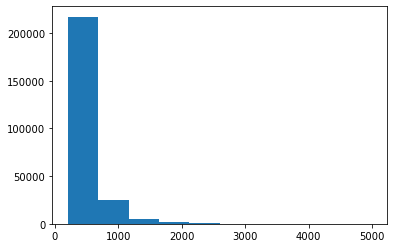

(250000,)
Number of outliers removed :  3293


In [16]:
outlier_mask=np.linalg.norm(X,axis=1)<1500
plt.hist(np.linalg.norm(X,axis=1))
plt.show()
print(outlier_mask.shape)
# outliers removal
X = X[outlier_mask]
y = y[outlier_mask]
print('Number of outliers removed : ', np.sum(~outlier_mask))

## Logistic Regression

In [60]:
reg_logistic_regression(y,X,lambda_=1000,initial_w=np.zeros((X.shape[1])),max_iters=1,gamma=1e-7)

(array([-0.01710043, -0.01710043, -0.01710043, -0.01710043, -0.01710043,
        -0.01710043, -0.01710043, -0.01710043, -0.01710043, -0.01710043,
        -0.01710043, -0.01710043, -0.01710043, -0.01710043, -0.01710043,
        -0.01710043, -0.01710043, -0.01710043, -0.01710043, -0.01710043,
        -0.01710043, -0.01710043, -0.01710043, -0.01710043, -0.01710043,
        -0.01710043, -0.01710043, -0.01710043, -0.01710043, -0.01710043]),
 -1627845.296576539)

In [70]:
from cross_validation import hyper_parameter_optimisation
degrees = np.arange(1,3)
lambdas = np.logspace(-4, 3, 1)
gammas = np.logspace(-10, -8, 2)
params={'degree':degrees,'gamma':gammas,'lambda':lambdas,}
#call to the grid search function
best_param = hyper_parameter_optimisation(params,X,y)
#least_squares_SGD(y, X,np.zeros((X.shape[1])), 100, 1e-6)

Evaluated for {'degree': 1, 'gamma': 1e-10, 'lambda': 0.0001} : loss = 1.008366841452305
Evaluated for {'degree': 1, 'gamma': 1e-08, 'lambda': 0.0001} : loss = 48.73600217841553
Evaluated for {'degree': 2, 'gamma': 1e-10, 'lambda': 0.0001} : loss = 1.0093814069424536
Evaluated for {'degree': 2, 'gamma': 1e-08, 'lambda': 0.0001} : loss = 65.96537388245808
(2, 2, 1)
======== Best test loss for parameters {'degree': 1, 'gamma': 1e-10, 'lambda': 0.0001} ========
======== Best test loss score 1.008366841452305 ========
{'degree': 1, 'gamma': 1e-10, 'lambda': 0.0001}


# Cross Validation


In [25]:
from cross_validation import grid_search_cv

degrees = np.arange(5,7)
lambdas = np.logspace(-4, -2, 20)
params={'degree':degrees,'lambda':lambdas}
#call to the grid search function
best_param = grid_search_cv(params,X,y,k_fold=4)

Evaluated for {'degree': 5, 'lambda': 0.0001} : loss = 0.7726693494782806
Evaluated for {'degree': 5, 'lambda': 0.00012742749857031334} : loss = 0.7726693274082003
Evaluated for {'degree': 5, 'lambda': 0.0001623776739188721} : loss = 0.7726692980044576
Evaluated for {'degree': 5, 'lambda': 0.00020691380811147902} : loss = 0.772669259493117
Evaluated for {'degree': 5, 'lambda': 0.00026366508987303583} : loss = 0.7726692095868173
Evaluated for {'degree': 5, 'lambda': 0.0003359818286283781} : loss = 0.7726691453472049
Evaluated for {'degree': 5, 'lambda': 0.00042813323987193956} : loss = 0.7726690630139066
Evaluated for {'degree': 5, 'lambda': 0.000545559478116852} : loss = 0.7726689577899933
Evaluated for {'degree': 5, 'lambda': 0.0006951927961775605} : loss = 0.772668823574352
Evaluated for {'degree': 5, 'lambda': 0.0008858667904100823} : loss = 0.772668652627313
Evaluated for {'degree': 5, 'lambda': 0.0011288378916846883} : loss = 0.7726684351570111
Evaluated for {'degree': 5, 'lambda'

## Train final model with the best parameters

In [26]:
from build_polynomial import PolynomialExpansion

degree  = best_param['degree']
lambda_ = best_param['lambda']

expanser = PolynomialExpansion(degree,with_scaler=True)
tX       = expanser.expand(X)
weights,loss_tr = ridge_regression(y,tX,lambda_)

# Model evaluation

In [27]:
def evaluate_model(x,y,w, print_=False):
    pred=predict_labels(w, x)
    false_positive=np.sum(pred>y)
    false_negative=np.sum(pred<y)
    true_positive=np.sum((pred==y) * (y==np.ones(len(y))*1))
    true_negative=np.sum((pred==y) * (y==np.ones(len(y))*-1))
    confusion_matrix=[[true_positive,false_positive],[false_negative,true_negative]]
    if print_:
        print("==============================")
        print('precision=',true_positive/(true_positive+false_positive))
        print('accuracy=',(true_positive+true_negative)/len(pred))
        print('recall=',true_positive/(true_positive+false_negative))
        print('f1=',true_positive/(true_positive+0.5*(false_negative+false_positive)))
        print("confusion matrix:")
        print(confusion_matrix[0])
        print(confusion_matrix[1])
        print("==============================")   
    
    return (true_positive+true_negative)/len(pred)

In [37]:
evaluate_model(tX,y,weights, print_=True)

precision= 0.7313864372077581
accuracy= 0.7987126429327096
recall= 0.6361251819855375
f1= 0.6804378462904689
confusion matrix:
[52869, 19417]
[30242, 144179]


0.7987126429327096

# Generate predictions and save ouput in csv format for submission:

In [20]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download train data and supply path here 
y_sub, X_sub, ids_sub = load_csv_data(DATA_TEST_PATH)
X_sub.shape

(568238, 30)

## Apply same transformation pipeline

In [22]:
Xt_sub = interpolator.interpolate(X_sub)
Xt_sub = expanser.expand(Xt_sub)

## Prediction 

In [23]:
y_pred = predict_labels(weights, Xt_sub)
np.sum(y_pred)/len(y_pred)

-0.40925457290783085

## Save output for submission 

In [87]:
OUTPUT_PATH = 'data/submission.csv' # TODO: fill in desired name of output file for submission

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)